# Analyse de la qualité de l'air à Grenoble

Ce document présente une tentative d'analyse de l'évolution de la qualité de l'air à Grenoble au cours des dernières années.

Les analyses ci-dessous ont été réalisées avec le langage de programmation R et les bibliothèques suivantes :

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(patchwork)
library(lubridate)
library(zoo)
library(patchwork)
library(broom)
library(repr)
library(prophet)
options(repr.plot.width=12, repr.plot.height=8)
R.version.string


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: Rcpp
Loading required package: rlang


[1] "R version 3.5.2 (2018-12-20)"

## Récupération et nettoyage des données

Toutes les données ont été récupérées sur le site d'[Atmo](https://www.atmo-auvergnerhonealpes.fr/donnees/telecharger) en remplissant le formulaire. Les différents fichiers ainsi téléchargés se trouvent dans le dossier [data](data).

Le format de données est particulièrement pénible, une colonne par date. On va d'abord restructurer ça pour avoir une observation par ligne. On convertit également les colonnes `Date` et `Valeur` dans les types adéquats.

In [2]:
filename = 'data/2005-2020_daily.csv'
df = read.csv(filename, sep=';') %>%
    mutate_all(as.character) %>%
    pivot_longer(c(-Station, -Polluant, -Mesure, -Unité), names_to="raw_date", values_to="Valeur", names_prefix="X") %>%
    mutate(Date=parse_date_time(raw_date, "dmy"), Valeur=as.numeric(sub(",", ".", Valeur))) %>%
    filter(Date < parse_date_time("01/01/2020", "dmy"))
str(df)
head(df)

Warning message:
“NAs introduits lors de la conversion automatique”

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	98604 obs. of  7 variables:
 $ Station : chr  "Grenoble Rocade Sud" "Grenoble Rocade Sud" "Grenoble Rocade Sud" "Grenoble Rocade Sud" ...
 $ Polluant: chr  "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" ...
 $ Mesure  : chr  "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" ...
 $ Unité   : chr  "microg/m3" "microg/m3" "microg/m3" "microg/m3" ...
 $ raw_date: chr  "01.01.2005" "02.01.2005" "03.01.2005" "04.01.2005" ...
 $ Valeur  : num  57 43 66 61 83 81 75 73 56 82 ...
 $ Date    : POSIXct, format: "2005-01-01" "2005-01-02" ...


Station,Polluant,Mesure,Unité,raw_date,Valeur,Date
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dttm>
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2005,57,2005-01-01
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,02.01.2005,43,2005-01-02
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,03.01.2005,66,2005-01-03
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,04.01.2005,61,2005-01-04
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,05.01.2005,83,2005-01-05
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,06.01.2005,81,2005-01-06


In [3]:
df %>% group_by(Mesure) %>% count()

Mesure,n
<chr>,<int>
Dioxyde d'azote,21912
Dioxyde de soufre,5478
Monoxyde d'azote,21912
Ozone,10956
Particules PM10,21912
"Particules PM2,5",5478
Particules PM2.5,10956


On voit qu'il y a deux intitulés différents pour les PM 2.5, l'un avec une virgule, l'autre avec un point. On renomme celui avec la virgule.

In [4]:
df = df %>% mutate(Mesure=ifelse(grepl("Particules PM2", Mesure), "Particules PM2.5", Mesure))
df %>% group_by(Mesure) %>% count()

Mesure,n
<chr>,<int>
Dioxyde d'azote,21912
Dioxyde de soufre,5478
Monoxyde d'azote,21912
Ozone,10956
Particules PM10,21912
Particules PM2.5,16434


Un certain nombre de valeurs sont manquantes. On commence par regarder si elles ont une distribution particulière.

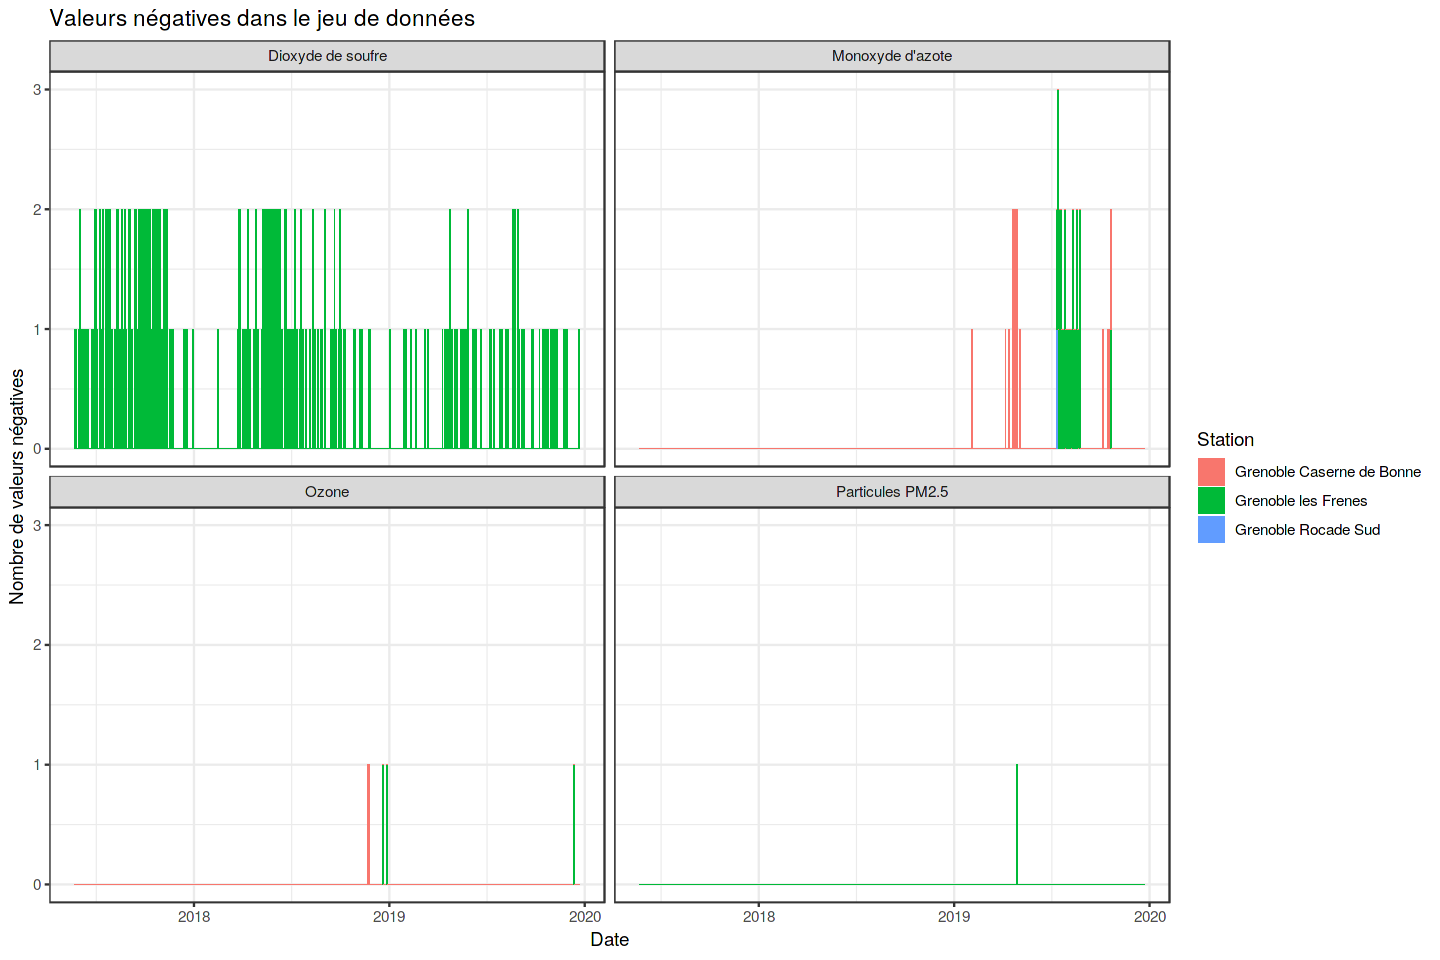

In [5]:
nb_days = as.numeric(max(df$Date) - min(df$Date))
df %>%
    filter(Valeur < 0) %>%
    ggplot() +
    aes(x=Date, fill=Station) +
    facet_wrap("Mesure") +
    geom_histogram(bins=nb_days/10) +
    theme_bw() +
    ylab("Nombre de valeurs négatives") +
    ggtitle("Valeurs négatives dans le jeu de données")

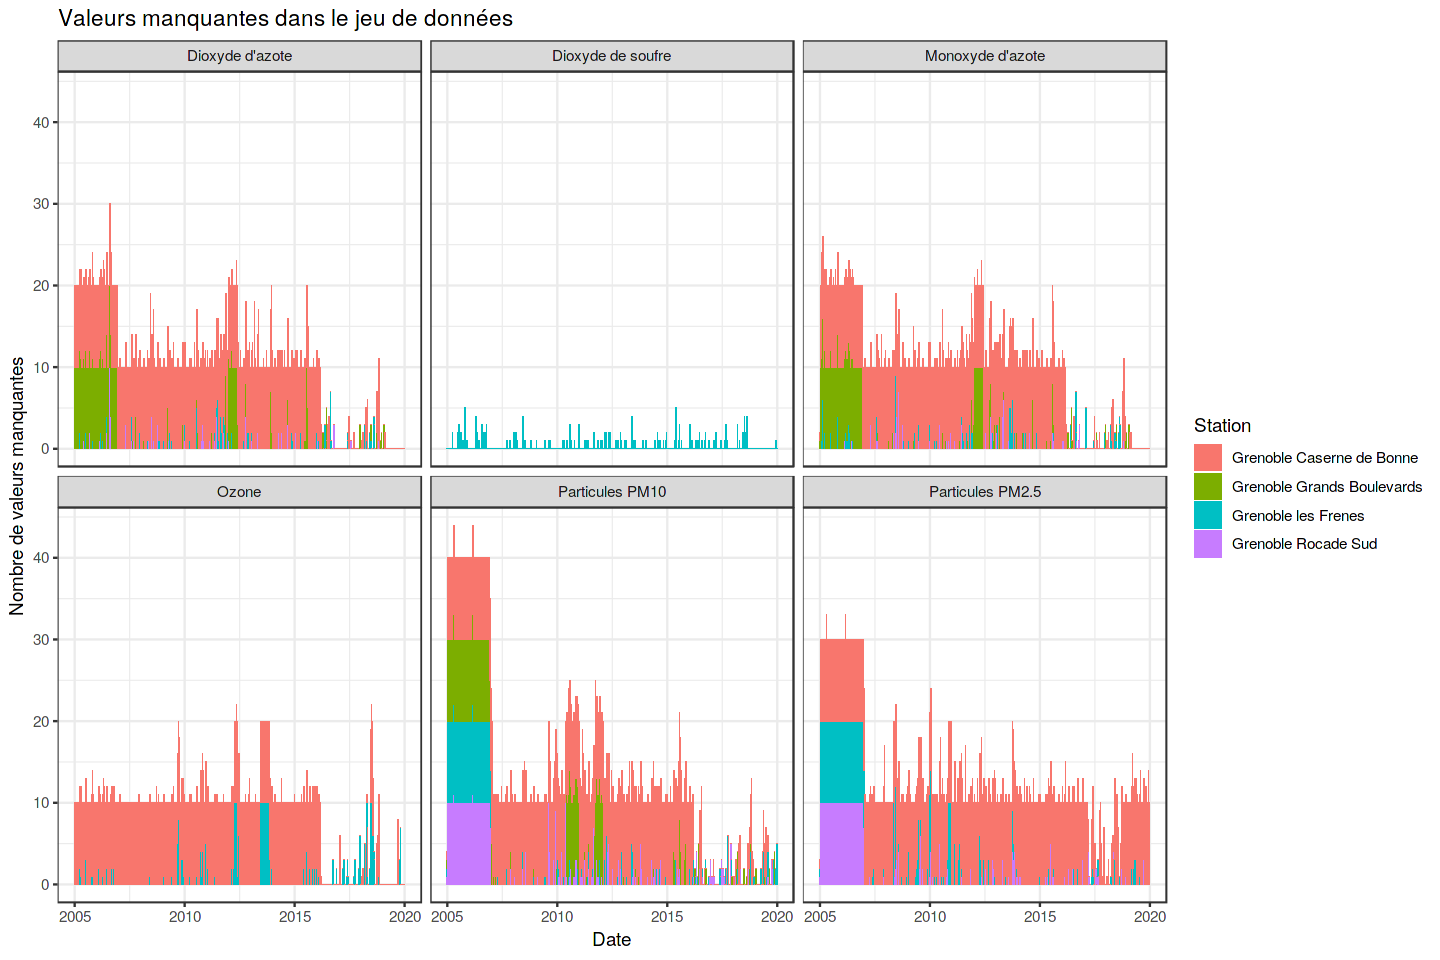

In [6]:
nb_days = as.numeric(max(df$Date) - min(df$Date))
df %>%
    filter(is.na(Valeur)) %>%
    ggplot() +
    aes(x=Date, fill=Station) +
    facet_wrap("Mesure") +
    geom_histogram(bins=nb_days/10) +
    theme_bw() +
    ylab("Nombre de valeurs manquantes") +
    ggtitle("Valeurs manquantes dans le jeu de données")

On peut constater des manques de données sur certaines periodes, pour certaines stations. Cela correspond probablement à des pannes des capteurs. Ça sera à garder en tête par la suite dans les interprétations des courbes. On supprime les entrées avec des données manquantes.

In [7]:
df = df %>% drop_na()

## Évolution et prédiction

On utilise la bibliothèque [Prophet](https://facebook.github.io/prophet/), développée par Facebook pour faire des prédictions sur des séries temporelles comme la notre.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


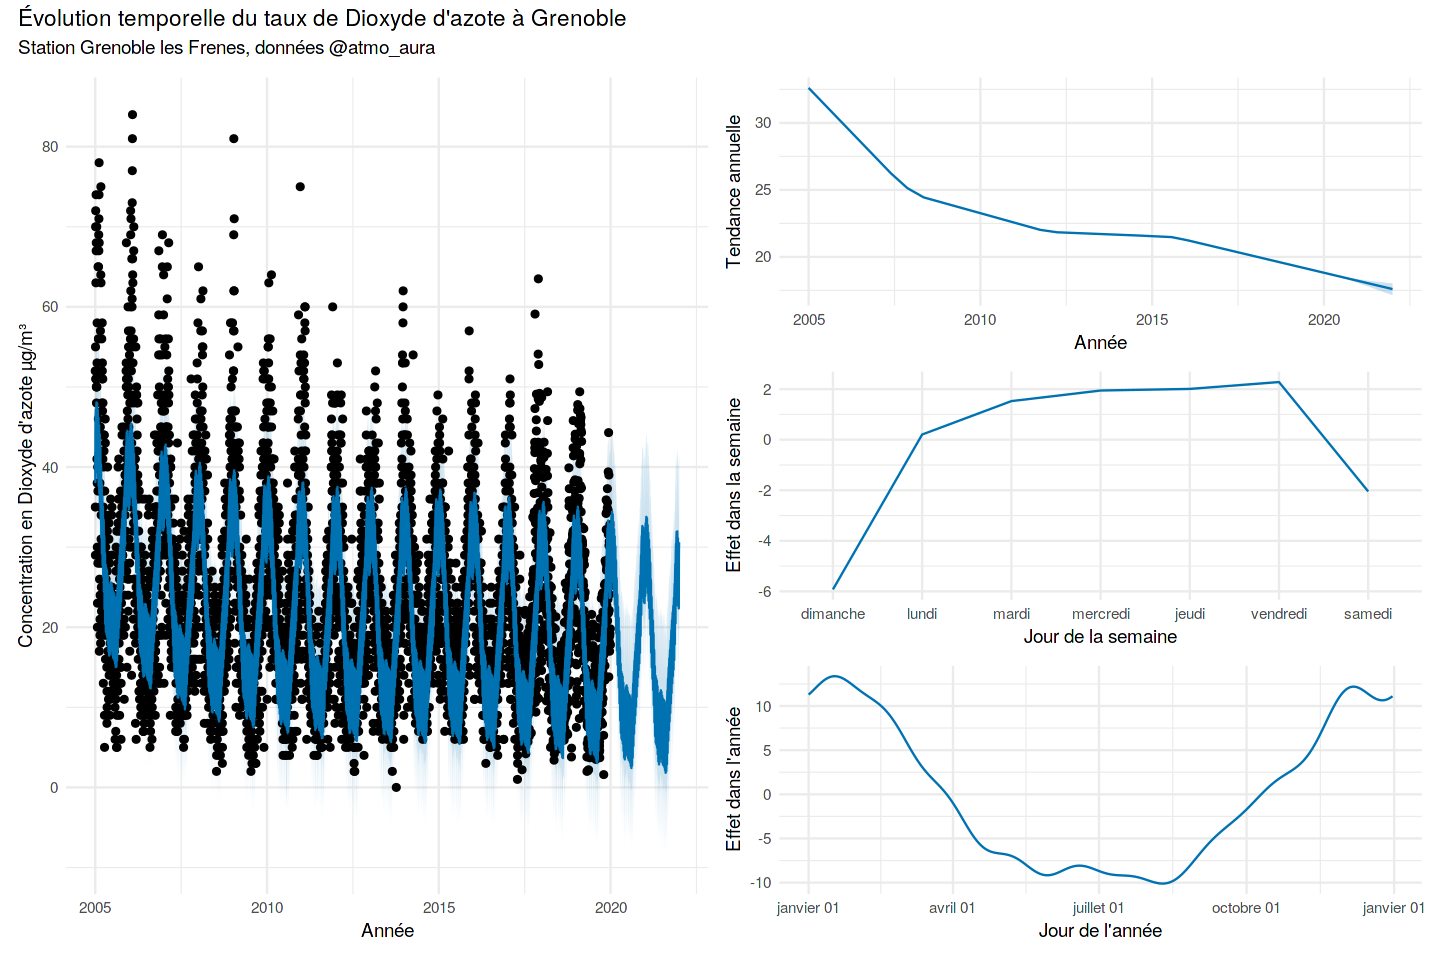

In [8]:
prophetize = function(df, station, polluant) {
    df = df %>% 
        filter(Station == station, Mesure == polluant) %>%
        mutate(ds=Date, y=Valeur)
    m = prophet(df)
    future = make_future_dataframe(m, periods = 2*365)
    forecast = predict(m, future)
    main_plot = plot(m, forecast) +
        ylab(paste("Concentration en", polluant, "µg/m³")) +
        xlab("Année")
    pdf(file = NULL) # disable the plot
    subplots = prophet_plot_components(m, forecast) # ← this function returns a list of plot *and* displays a plot...
    dev.off() # re-enable the plot
    stopifnot(length(subplots) == 3)
    plot_trend =  subplots[[1]] +
        xlab("Année") + ylab("Tendance annuelle")
    plot_weekly = subplots[[2]] +
        xlab("Jour de la semaine") + ylab("Effet dans la semaine")
    plot_yearly = subplots[[3]] +
        xlab("Jour de l'année") + ylab("Effet dans l'année")
    plot = (main_plot | (plot_trend / plot_weekly / plot_yearly)) +
        plot_annotation(
          title = paste("Évolution temporelle du taux de", polluant, "à Grenoble"),
          subtitle = paste("Station ", station, ", données @atmo_aura", sep="")
        ) &
        theme_minimal()
    return(plot)
}

prophetize(df, "Grenoble les Frenes", "Dioxyde d'azote")

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


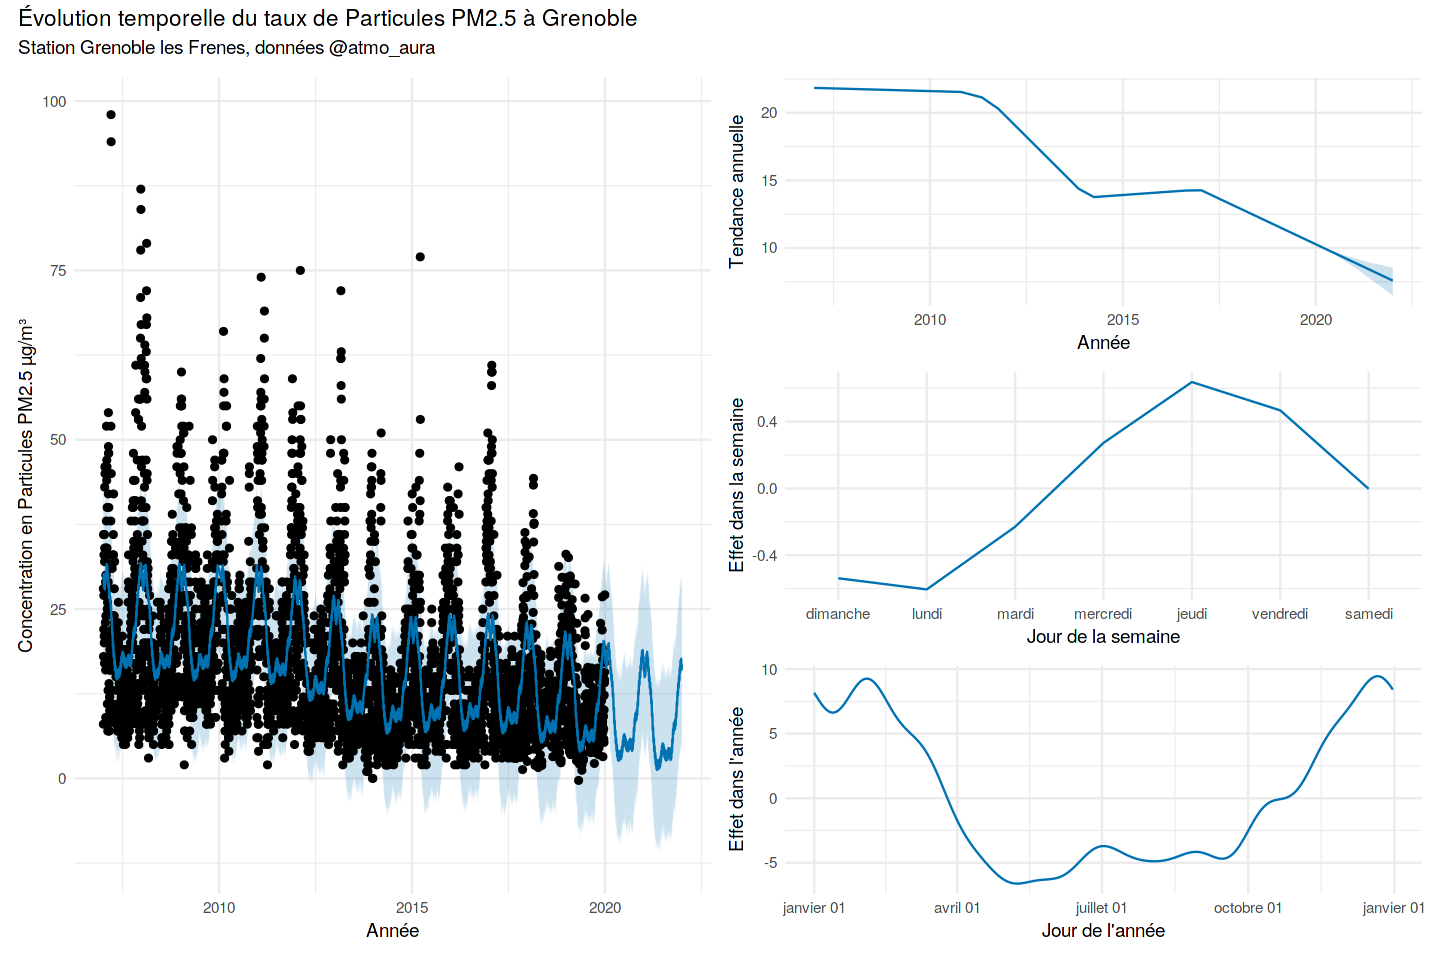

In [9]:
prophetize(df, "Grenoble les Frenes", "Particules PM2.5")

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


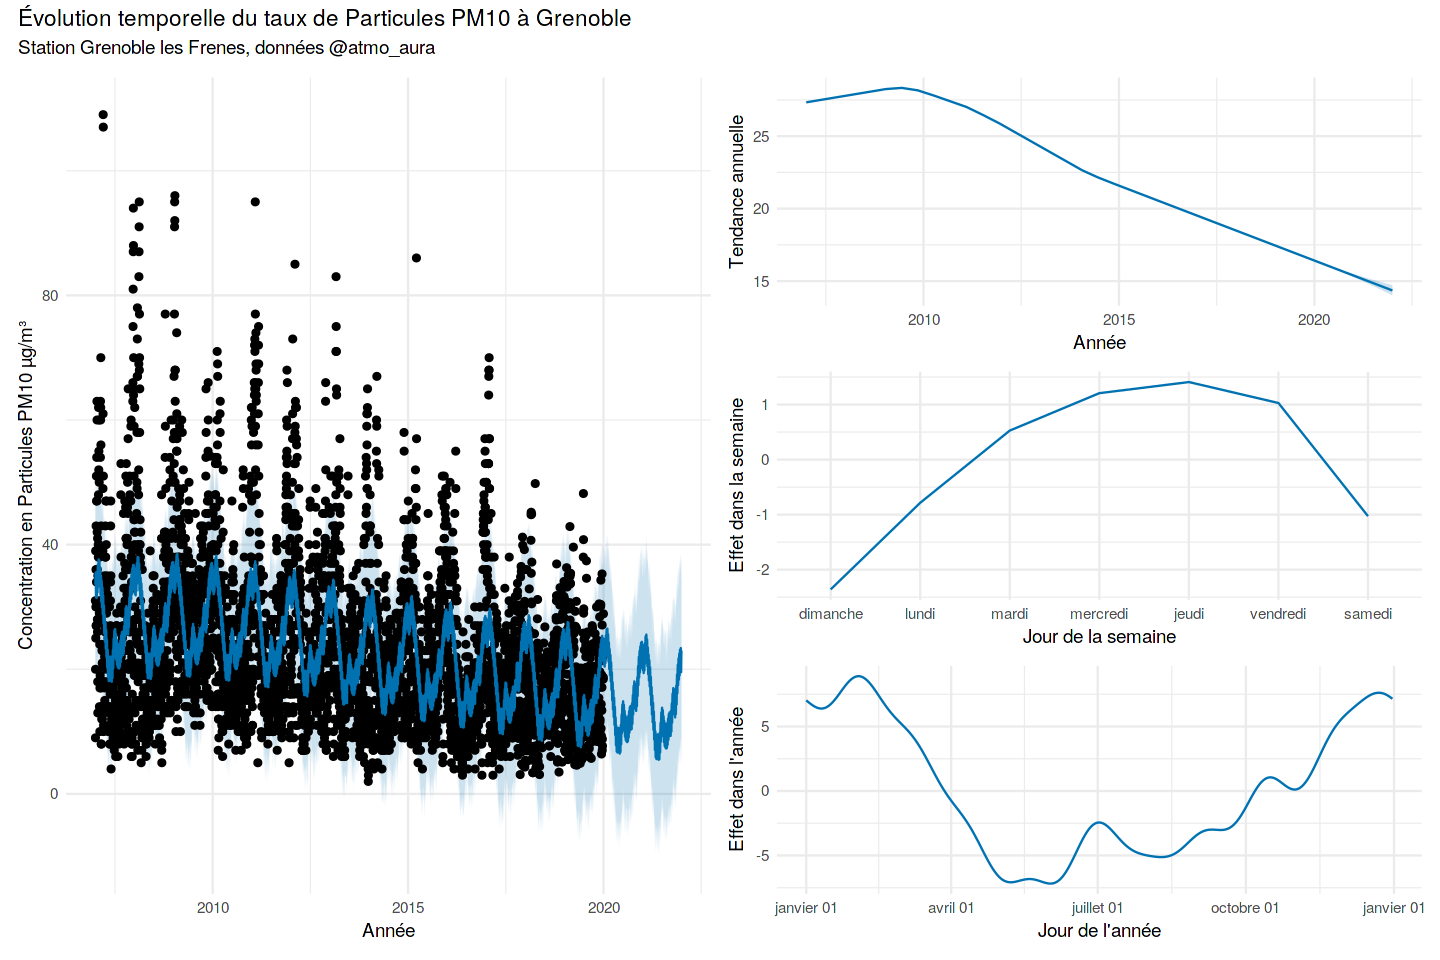

In [10]:
prophetize(df, "Grenoble les Frenes", "Particules PM10")